In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt



In [36]:
#Branching probabilities. a,b,c are letters in 0...q-1
# At each branching of the tree, if the letter is a, it generates 
# at the next level an ordered pair (b,c) with probability rho[a,b,c]
#By definition, for all a: sum_{b,c} rho[a,b,c]=1 
def calcrho_lognormal(q,sigma):
    logrho=np.random.normal(0,size=(q,q,q))*sigma
    rho2=np.zeros((q,q))
    for a in np.arange(q):
        lrmax=np.max(logrho[a,:,:])
        logrho[a,:,:]=logrho[a,:,:]-lrmax
    rho=np.exp(logrho)
    for a in np.arange(q):
        rho2=rho[a,:,:]
        sum2=np.sum(rho2)
        rho[a,:,:]=rho[a,:,:]/sum2
        
    return rho

# Conversion of b,c in [0,...,q-1]*[0,...,q-1] to nn in [0,...,q**2-1] and reciprocally
def calcnn(b,c):
    return b+q*c
def calcbc(nn):
    b=nn%q
    c=int((nn-b)/q)
    return b,c
#Broadcast: given a, generate b and c. 
def calcpsum(q,rho):
    p=np.zeros((q,q**2))
    psum=np.zeros((q,q**2))
    sumrule=np.zeros(q)
    for a in np.arange(q):
        for b in np.arange(q):
            for c in np.arange(q):
                nn=calcnn(b,c)
                p[a,nn]=rho[a,b,c]
        sumrule=np.sum(p,axis=1)
    #print('sumrule',sumrule)
    for a in np.arange(q):
        psum[a,0]=p[a,0]
        for i in np.arange(q**2-1):
            j=i+1
            psum[a,j]=psum[a,j-1]+p[a,j]
    return psum
def genbc(q,a,psum):
    x=np.random.uniform(0,1)
    pp=np.zeros(q**2)
    pp=psum[a,:]
    for i in np.arange(q**2):
        #print('x,i,pp[i]',x,i,pp[i])
        if pp[i]>x:
            b,c=calcbc(i)
            return b,c
        
def xlog_qx(q,x):
    if x==0 :
        return 0
    else:
        return x*np.log(x)/np.log(q)
    
def calc_rho_entrop(q,rho):
    ss=np.zeros(q)
    for a in np.arange(q):
        sum=0
        for b in np.arange(q):
            for c in np.arange(q):
                sum=sum-xlog_qx(q,rho[a,b,c])
        ss[a]=sum
    return np.mean(ss)/2

q=4
#u=1/100
#w=1/100#1/3-1/100
sigma=.01
rho = calcrho_lognormal(q,sigma)
psum=calcpsum(q,rho)
print('psum')
print(psum)
#print(rho)

for a in np.arange(q):
    print('a=',a,'rho=')
    print(rho[a,:,:])
    
print('entropy of rho, per output symbol',calc_rho_entrop(q,rho))

psum
[[0.06281103 0.12514823 0.1870812  0.24903491 0.31139427 0.37431575
  0.43786685 0.50070329 0.56352348 0.6255674  0.68812278 0.74985229
  0.81245021 0.87471336 0.93764161 1.        ]
 [0.06128249 0.12431869 0.1869708  0.24899312 0.31110944 0.37378427
  0.43683555 0.49854333 0.56177989 0.62396269 0.6870517  0.74899548
  0.81020807 0.87412067 0.93565617 1.        ]
 [0.06275976 0.12634681 0.18940722 0.25224398 0.31412732 0.37621391
  0.43756751 0.49945806 0.56077964 0.62320308 0.68642363 0.74813416
  0.81066377 0.87390254 0.93745974 1.        ]
 [0.06248291 0.12568078 0.18732158 0.2494736  0.31259993 0.37567002
  0.43857236 0.50062577 0.56323473 0.62493537 0.68688518 0.74882353
  0.81156763 0.8746526  0.93778587 1.        ]]
a= 0 rho=
[[0.06281103 0.06235936 0.06282019 0.06259792]
 [0.0623372  0.06292147 0.06204393 0.06226315]
 [0.06193297 0.0635511  0.06255537 0.06292824]
 [0.06195371 0.06283644 0.06172951 0.06235839]]
a= 1 rho=
[[0.06128249 0.06211632 0.06323656 0.06121259]
 [0.06

In [3]:
#Broadcast in a binary tree with K+1 generations
# r=0 has one point
#r=1 has 2 points
# level r has 2**r points
# there are N=2**K leafs at level r=K
#x[r,i] is the letter at the i-th point of layer r, where i in [0,...2**r-1]
# In practice I define x as a matrix of size K+1, 2**K but at each layer r I use only the
# first 2**r-1 components
def gen_x(K,q,rho,root):
    N=2**K
    x=np.zeros((K+1,N)).astype(int)
    x[0,0]=root
    for ir in np.arange(K):
        r=ir+1
        jnew=0
        for j in np.arange(2**ir):
            a=x[ir,j]
            b,c=genbc(q,a,psum)
            #print('r=',r,'jnew,jnew+1=',jnew,jnew+1)
            x[r,jnew]=b
            x[r,jnew+1]=c
            jnew=jnew+2
    #print('itry=',itry,'sequence obtained at generation K=',K)
    #print(x[K,:])
    return x

In [ ]:
# Small test of broadcast
K=3
N=2**K
root=0#np.random.randint(q)
ntry=1000
xxx=np.zeros((K+1,N)).astype(int)
xleaf=np.zeros((ntry,N)).astype(int)
xf=np.zeros((ntry,K+1,N)).astype(int)
for itry in np.arange(ntry):
    xxx=gen_x(K,q,rho,root)
    xf[itry,:,:]=xxx
    xleaf[itry,:]=xf[itry,K,:]
#print(xleaf)

[0.911 0.908 0.86  0.954 0.902 0.896 0.856 0.993]


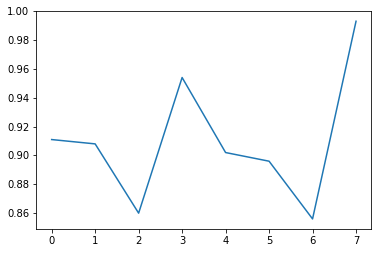

In [5]:
xm=np.mean(xleaf,axis=0)
print(xm)
plt.plot(xm)

In [6]:
# Geometry
# Create a global index of the sites. There are in total 2**(K+1)-1 sites
# We use indsite[r,j]=n, and its reverse layer [n]=r  inlayer[n]=j
def calc_geom(K):
    ntot=2**(K+1)-1
    indsite=np.zeros((K+1,2**K),dtype=int)
    layer= np.zeros(ntot,dtype=int)
    inlayer= np.zeros(ntot,dtype=int)
    site=0
    for r in np.arange(K+1):
        for j in np.arange(2**r):
            indsite[r,j]=site
            layer[site]=r
            inlayer[site]=j
            site=site+1
        #print('r',r,'j',j,'site number',site)
# Create table of neighbours desc[n,0] and desc[n,1] are the two descendants above n
# asc[n] is the ascendant below n. I use the index -1 when there is no ascendant or descendant
    asc=-np.ones(ntot,dtype=int)
    desc=-np.ones((ntot,2),dtype=int)
    for n in np.arange(ntot):
        r=layer[n]
        j=inlayer[n]
        jkl=(np.floor(j/2)).astype(int)
        if r==0:
            asc[n]=-1
            desc[n,0]=indsite[1,0]
            desc[n,1]=indsite[1,1]
        if r==K:
            desc[n,0]=-1
            desc[n,1]=-1
            asc[n]=indsite[r-1,jkl]
        if (0<r) and (r<K):
            asc[n]=indsite[r-1,jkl]
            desc[n,0]=indsite[r+1,2*j]
            desc[n,1]=indsite[r+1,2*j+1]
        #print('n=',n,'r,j',r,j,'asc',asc[n],'desc',desc[n,0],desc[n,1])
    return indsite,layer,inlayer,asc,desc

In [7]:
# Messages initialization
#Random
def initialize_messages(ntot,q):
    mup=np.random.uniform(0,1,size=(ntot,q))
    mdown=np.random.uniform(0,1,size=(ntot,q))
    mupsum=np.sum(mup,axis=1)
    mdownsum=np.sum(mdown,axis=1)
    for n in np.arange(ntot):
        for p in np.arange(q):
            mup[n,p]=mup[n,p]/mupsum[n]
            mdown[n,p]=mdown[n,p]/mdownsum[n]
            if layer[n]==0:
                mup[n,p]=1/q
            if layer[n]==K:
                mdown[n]=1/q
    return mup,mdown
#Random with constraint on the leaves and root
def initialize_messages_constraint(ntot,q,root,x,indsite):
    mup=np.random.uniform(0,1,size=(ntot,q))
    mdown=np.random.uniform(0,1,size=(ntot,q))
    mupsum=np.sum(mup,axis=1)
    mdownsum=np.sum(mdown,axis=1)
    for n in np.arange(ntot):
        for p in np.arange(q):
            mup[n,p]=mup[n,p]/mupsum[n]
            mdown[n,p]=mdown[n,p]/mdownsum[n]
            if layer[n]==0:
                mup[n,p]=1/q
            if layer[n]==K:
                mdown[n]=1/q
    for p in np.arange(q):
        mup[0,p]=0
    mup[0,root]=1
    for j in np.arange(2**K):
        n=indsite[K,j]
        for p in np.arange(q):
            mdown[n,p]=0
        mdown[n,x[j]]=1        
    return mup,mdown


In [38]:
#Messages update
def calc_mout(q,inup,inleft,inright,rho):
    outdown=np.zeros(q)
    outleft=np.zeros(q)
    outright=np.zeros(q)
    for jdown in np.arange(q):
        sumt=0
        for jleft in np.arange(q):
            for jright in np.arange(q):
                sumt=sumt+inleft[jleft]*inright[jright]*rho[jdown,jleft,jright]
        outdown[jdown]=sumt
    sm=np.sum(outdown)
    outdown=outdown/sm
    for jleft in np.arange(q):
        sumt=0
        for jup in np.arange(q):
            for jright in np.arange(q):
                sumt=sumt+inup[jup]*inright[jright]*rho[jup,jleft,jright]
        outleft[jleft]=sumt
    sm=np.sum(outleft)
    outleft=outleft/sm
    for jright in np.arange(q):
        sumt=0
        for jup in np.arange(q):
            for jleft in np.arange(q):
                sumt=sumt+inup[jup]*inleft[jleft]*rho[jup,jleft,jright]
        outright[jright]=sumt
    sm=np.sum(outright)
    outright=outright/sm
    return outdown,outleft,outright
        
def update_messages(ntot,q,mup,mdown,asc,desc,rho):
    #print('check init update mess')
    #print('ntot=',ntot,'q=',q,np.shape(mup),np.shape(mdown),np.shape(asc),np.shape(desc))
    inleft=np.zeros(q)
    inright=np.zeros(q)
    inup=np.zeros(q)
    mupnew=np.copy(mup)
    mdownnew=np.copy(mdown)
    #Here to be done these loops should be parallelized 
    for r in np.arange(K): 
        for j in np.arange(2**r):
                n=indsite[r,j]# This is also the index of the factor node above the variable
                inup=mup[n,:]
                #print('check',n,asc[n],desc[n,0],desc[n,1])
                inleft=mdown[desc[n,0],:]
                inright=mdown[desc[n,1],:]
                outdown,outleft,outright=calc_mout(q,inup,inleft,inright,rho)
                mdownnew[n,:]=outdown
                mupnew[desc[n,0],:]=outleft
                mupnew[desc[n,1],:]=outright
    return mupnew,mdownnew
#Run BP until convergence
def BP_iter(ntot,q,mupinit,mdowninit,asc,desc,rho):
    mup=np.copy(mupinit)
    mdown=np.copy(mdowninit)
    for iter in np.arange(2*K+5):
        mupnew,mdownnew=update_messages(ntot,q,mup,mdown,asc,desc,rho)
        errmess=np.sum((mupnew-mup)**2)+np.sum((mdownnew-mdown)**2)
        mup=np.copy(mupnew)
        mdown=np.copy(mdownnew)
        if(errmess<1.e-6):
            break
    return mup,mdown
#Compute the free entropy of the tree with constraints x_0=root
# and x_Boundary=x. Returns minus the free entropy divided by the size
# of the boundary
def calc_entrop_messages(mup,mdown,rho,ntot,q,K,desc,indsite):
    phi_fact=0
    for r in np.arange(K):
        for j in np.arange(2**r):
            n=indsite[r,j]
            sumtot=0
            for p1 in np.arange(q):
                for p2 in np.arange(q):
                    for p3 in np.arange(q):
                        sumtot=sumtot+mdown[desc[n,0],p1]*mdown[desc[n,1],p2]*mup[n,p3]*rho[p3,p1,p2]
            #print('test',r,j,n,sumtot)
            phi_fact=phi_fact+np.log(sumtot)/np.log(q)
    phi_var=0
    for r in np.arange(1,K):
        for j in np.arange(2**r):
            n=indsite[r,j]
            sumtot=0
            for p1 in np.arange(q):
                sumtot=sumtot+mup[n,p1]*mdown[n,p1]
            phi_var=phi_var+np.log(sumtot)/np.log(q)
    return -(phi_fact-phi_var)/2**K

In [40]:
#Main

#Define the geometry
K=8
N=2**K
ntot=2**(K+1)-1
indsite,layer,inlayer,asc,desc=calc_geom(K)
#Compute the transition tensor M
q=3
numsigma=12
numMat=20
av_ent=np.zeros((numsigma,numMat))
ste_ent=np.zeros((numsigma,numMat))
rho_ent=np.zeros((numsigma,numMat))
sigmag=np.zeros(numsigma)
for isigma in np.arange(numsigma):
    sigma=.2+(isigma)/1.5
    sigmag[isigma]=sigma
    for iMat in np.arange(numMat):
        rho = calcrho_lognormal(q,sigma)
        psum=calcpsum(q,rho)
        rho_ent[isigma,iMat]=calc_rho_entrop(q,rho)
#Broadcast
        root=0#np.random.randint(q)
        ntry=3
        xxx=np.zeros((K+1,N)).astype(int)
        xleaf=np.zeros((ntry,N)).astype(int)
        xf=np.zeros((ntry,K+1,N)).astype(int)
        for itry in np.arange(ntry):
            xxx=gen_x(K,q,rho,root)
            xf[itry,:,:]=xxx
            xleaf[itry,:]=xf[itry,K,:]
#Solve BP and compute the entropy per variable
        etm=np.zeros(ntry)
        for itry in np.arange(ntry):
            x=xleaf[itry,:]
            mupinit,mdowninit=initialize_messages_constraint(ntot,q,root,x,indsite)
            mup,mdown=BP_iter(ntot,q,mupinit,mdowninit,asc,desc,rho)
            entropmes=calc_entrop_messages(mup,mdown,rho,ntot,q,K,desc,indsite)
            etm[itry]=entropmes
        print('sigma',sigma,'iMat',iMat,'itry=',itry,'entropmes=',np.mean(etm))
        av_ent[isigma,iMat]=np.mean(etm)
        ste_ent[isigma,iMat]=np.std(etm)/np.sqrt(ntry)
print('done')

sigma 0.2 iMat 0 itry= 2 entropmes= 1.0011828369331806
sigma 0.2 iMat 1 itry= 2 entropmes= 0.9961928006727199
sigma 0.2 iMat 2 itry= 2 entropmes= 0.9897696439743114
sigma 0.2 iMat 3 itry= 2 entropmes= 0.9988371765586361
sigma 0.2 iMat 4 itry= 2 entropmes= 0.995483232935981
sigma 0.2 iMat 5 itry= 2 entropmes= 1.003997471794284
sigma 0.2 iMat 6 itry= 2 entropmes= 0.9947188460062227
sigma 0.2 iMat 7 itry= 2 entropmes= 0.9993737566708875
sigma 0.2 iMat 8 itry= 2 entropmes= 0.9971801718260108
sigma 0.2 iMat 9 itry= 2 entropmes= 1.0015352817025982
sigma 0.2 iMat 10 itry= 2 entropmes= 1.001947715024181
sigma 0.2 iMat 11 itry= 2 entropmes= 0.997441265029241
sigma 0.2 iMat 12 itry= 2 entropmes= 1.0011657415162103
sigma 0.2 iMat 13 itry= 2 entropmes= 0.9986951652021281
sigma 0.2 iMat 14 itry= 2 entropmes= 0.9979786991723906
sigma 0.2 iMat 15 itry= 2 entropmes= 0.9981057315370098
sigma 0.2 iMat 16 itry= 2 entropmes= 0.9928837694079681
sigma 0.2 iMat 17 itry= 2 entropmes= 1.0000284711451919
sigma 

sigma 4.2 iMat 7 itry= 2 entropmes= 0.5202833110493835
sigma 4.2 iMat 8 itry= 2 entropmes= 0.4793104536098775
sigma 4.2 iMat 9 itry= 2 entropmes= 0.5276173864477265
sigma 4.2 iMat 10 itry= 2 entropmes= 0.5580363481286185
sigma 4.2 iMat 11 itry= 2 entropmes= 0.5679834392292948
sigma 4.2 iMat 12 itry= 2 entropmes= 0.5869279386517549
sigma 4.2 iMat 13 itry= 2 entropmes= 0.7121443527188441
sigma 4.2 iMat 14 itry= 2 entropmes= 0.634136287174929
sigma 4.2 iMat 15 itry= 2 entropmes= 0.8406078216958816
sigma 4.2 iMat 16 itry= 2 entropmes= 0.6839708616378958
sigma 4.2 iMat 17 itry= 2 entropmes= 0.7557769107220094
sigma 4.2 iMat 18 itry= 2 entropmes= 0.6801563392886466
sigma 4.2 iMat 19 itry= 2 entropmes= 0.14767511987383714
sigma 4.866666666666667 iMat 0 itry= 2 entropmes= 0.5701846873512457
sigma 4.866666666666667 iMat 1 itry= 2 entropmes= 0.7643056254241221
sigma 4.866666666666667 iMat 2 itry= 2 entropmes= 0.42844263500902174
sigma 4.866666666666667 iMat 3 itry= 2 entropmes= 0.301131290854521

In [41]:
for isigma in np.arange(numsigma):
    print('sigma=',sigmag[isigma],'ent=',av_ent[isigma,:],'+-',ste_ent[isigma,:])

sigma= 0.2 ent= [1.00118284 0.9961928  0.98976964 0.99883718 0.99548323 1.00399747
 0.99471885 0.99937376 0.99718017 1.00153528 1.00194772 0.99744127
 1.00116574 0.99869517 0.9979787  0.99810573 0.99288377 1.00002847
 1.00093478 0.99292809] +- [0.00037288 0.00067307 0.00506585 0.00029524 0.00163214 0.00060898
 0.00198109 0.00229096 0.00077311 0.00182006 0.0008649  0.00156837
 0.0009372  0.00100407 0.00145317 0.00141104 0.00176315 0.00094794
 0.00144644 0.00158441]
sigma= 0.8666666666666667 ent= [0.95209257 0.97165024 0.96129112 0.93816172 0.93268627 0.97621923
 0.97569729 0.94423407 0.92558831 0.92435587 0.95842397 0.97475301
 0.9640017  0.94627029 0.97205154 0.98892479 0.96504273 0.95906676
 0.98132879 0.97167115] +- [0.00694041 0.0042984  0.01456942 0.01351668 0.00721254 0.00150277
 0.00421247 0.0033845  0.00070536 0.01360004 0.00883184 0.00453283
 0.00272136 0.01245925 0.00643444 0.00176502 0.00569513 0.00460116
 0.00596638 0.00715208]
sigma= 1.5333333333333332 ent= [0.96845564 0.91

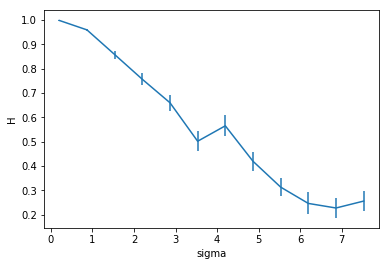

In [52]:
#plt.plot(sigmag,np.mean(av_ent,axis=1))
fig, ax = plt.subplots()
ax.errorbar(sigmag,np.mean(av_ent,axis=1),np.std(av_ent,axis=1)/np.sqrt(numMat-1))
plt.xlabel('sigma')
plt.ylabel('H')
plt.savefig('entropy_vs_sigma.pdf')
plt.show()

In [55]:
for isi in np.arange(numsigma):
    print(isi,sigmag[isi])

0 0.2
1 0.8666666666666667
2 1.5333333333333332
3 2.2
4 2.8666666666666667
5 3.5333333333333337
6 4.2
7 4.866666666666667
8 5.533333333333333
9 6.2
10 6.866666666666667
11 7.533333333333333


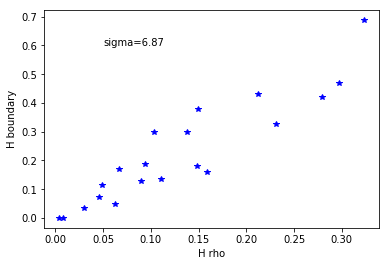

In [58]:
isigma=10
plt.plot(rho_ent[isigma,:],av_ent[isigma,:],'b*')
plt.xlabel('H rho')
plt.ylabel('H boundary')
plt.text(.05,.6,'sigma=6.87')
plt.savefig('entropyB vs entropy rho.pdf')
plt.show()